#### install libraries

In [1]:
#from google.colab import files
#upload = files.upload()
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [2]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 3.2 MB/s eta 0:00:00


In [3]:
#
import re
import numpy as np
import pandas as pd
from pprint import pprint


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing  # to normalize data for cosine similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier


# Plotting tools
#!pip install pyLDAvis
#import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [9]:
df = pd.read_csv(r'/content/mydrive/MyDrive/luis/study/master/tesis/automaticLabels/aprenderAProgramarFinalDataFrameWithCalificacion.csv',sep=';')

# some comments appear two times in the same categorie, in the text data, so we replace the number 2 for a 1
df = df.replace(2, 1)

df

,comment,ambiente,bondadesPlataforma,CbondadesPlataformaCcasosPrueba,CbondadesPlataformaCconocerErrores,CbondadesPlataformaCconsejosFormativos,CbondadesPlataformaCdisponibilidadLinea,CbondadesPlataformaCespacioTrabajo,CbondadesPlataformaCfacilidadUso,CbondadesPlataformaClenguajes,...,CMejorableAprenderProgramarCfallasGenerales,CMejorableAprenderProgramarCinflexibilidad,CMejorableAprenderProgramarCobjetivoEducativo,CMejorableAprenderProgramarCretroalimentacionInsuficiente,CMejorableAprenderProgramarCsustituible,colab,HerramientasUNcode,logrosPedagogicos,MejorableAprenderProgramar,calificacion
0,A traves de la plataforma pude ir practicando ...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NO CALIFICADO
1,A traves de los ejercicios propuestos en la he...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Totalmente de acuerdo
2,A veces UNCode no dejaba correr por cosas triv...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,Algo de acuerdo
3,A veces es poco practico y da errores por cosa...,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,Algo en desacuerdo
4,"A veces la pagina era muy lenta, y al principi...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,NO CALIFICADO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,si porque gracias a el pude constatar que mis ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,De acuerdo
343,"si, ya que es bastante sencillo e intuitivo a ...",0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,NO CALIFICADO
344,solo lo use para enviar los talleres ya que lo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,En desacuerdo
345,uno de los aspectos que considero que mas me c...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Totalmente de acuerdo


In [10]:
df2 = df[["comment", "bondadesPlataforma", "HerramientasUNcode","logrosPedagogicos","MejorableAprenderProgramar"]]
df2

,comment,bondadesPlataforma,HerramientasUNcode,logrosPedagogicos,MejorableAprenderProgramar
0,A traves de la plataforma pude ir practicando ...,1,0,0,0
1,A traves de los ejercicios propuestos en la he...,1,0,1,0
2,A veces UNCode no dejaba correr por cosas triv...,0,0,0,1
3,A veces es poco practico y da errores por cosa...,0,0,0,1
4,"A veces la pagina era muy lenta, y al principi...",0,0,1,0
...,...,...,...,...,...
342,si porque gracias a el pude constatar que mis ...,0,0,1,0
343,"si, ya que es bastante sencillo e intuitivo a ...",1,0,0,0
344,solo lo use para enviar los talleres ya que lo...,0,0,1,0
345,uno de los aspectos que considero que mas me c...,1,1,0,0


In [11]:
#df2 el de colab
#dfLLM
#iterar sobre cada uno de esos elementos, regex a

# Step 1: Read .txt file and parse lines
txt_comments = []
txt_categories = []

with open('/content/mydrive/MyDrive/luis/study/master/tesis/responseWithManualCategories.txt', 'r') as file:
  lines = file.readlines()
  for line in lines:
    if line.strip() == '':
        continue
    parts = line.strip().split(" - ")

    comment = parts[0].strip()
    categories = [x.strip() for x in parts[1].split(", ")]

    txt_comments.append(comment)
    txt_categories.append(categories)

# Step 2: Read .csv file
df_csv = df2
# Step 3: Transform categories
txt_transformed = []

for categories in txt_categories:
    bondadesPlataforma = int('Bondades de la plataforma' in categories)
    HerramientasUNcode = int('Herramientas de UNCode' in categories)
    logrosPedagogicos = int('Logros pedagógicos generales' in categories)
    MejorableAprenderProgramar = int('Mejorable para aprender a programar' in categories)

    txt_transformed.append([bondadesPlataforma, HerramientasUNcode, logrosPedagogicos, MejorableAprenderProgramar])

# Step 4: Comparison logic (as per your needs)

# Create a DataFrame from the txt file
df_txt = pd.DataFrame({
    'comment': txt_comments,
    'bondadesPlataforma': [x[0] for x in txt_transformed],
    'HerramientasUNcode': [x[1] for x in txt_transformed],
    'logrosPedagogicos': [x[2] for x in txt_transformed],
    'MejorableAprenderProgramar': [x[3] for x in txt_transformed]
})

# You can then use pd.merge() or other comparison logic to compare the two DataFrames


In [12]:
df_txt

,comment,bondadesPlataforma,HerramientasUNcode,logrosPedagogicos,MejorableAprenderProgramar
0,"1. ""Respecto a otros IDE que toca iniciar de c...",1,1,0,0
1,"2. ""Por la facilidad en plantear problemas y e...",1,0,0,0
2,"3. ""Ya que la interfaz no me parece muy comoda...",0,0,0,1
3,"4. ""Mediante la realizacion de los talleres, e...",0,1,1,0
4,"5. ""Fue un buen programa con una buena cantida...",1,0,1,0
...,...,...,...,...,...
65,"66. ""Porque presenta herramientas utiles que p...",0,1,0,0
66,"67. ""Es una herramienta que se adapta a las ne...",1,1,0,0
67,"68. ""Porque se pueden ver claramente algunos o...",1,1,0,0
68,"69. ""Por ser capaz de mostrar la coincidencia ...",0,1,0,0


In [13]:
import unidecode

def normalize_text(text):
    text = unidecode.unidecode(text)  # remove accents
    text = text.lower()  # convert to lowercase
    text = ' '.join(text.split())  # remove extra spaces
    return text


df2['normalized_comments'] = df['comment'].apply(normalize_text)
df_txt['normalized_comments'] = df_txt['comment'].apply(normalize_text)

<ipython-input-13-ebe92c2a4716>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['normalized_comments'] = df['comment'].apply(normalize_text)


In [41]:
from fuzzywuzzy import process
import pandas as pd

# Initialize counters
counters = {
    'bondadesPlataforma': {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0},
    'HerramientasUNcode': {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0},
    'logrosPedagogicos': {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0},
    'MejorableAprenderProgramar': {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0},
}

matched_rows = []

y_test = []
y_pred = []

for comment in df_txt['normalized_comments']:
    best_match, score = process.extractOne(comment, df2['normalized_comments'].tolist())
    if score < 90:
        continue

    matched_row = df2[df2['normalized_comments'] == best_match]
    matched_rows.append(matched_row)

    original_row = df_txt[df_txt['normalized_comments'] == comment].iloc[0]

    y_test.append(matched_row.iloc[0][1:5].values.astype(int))
    y_pred.append(original_row[1:5].values.astype(int))

    # Compare each category
    for category in ['bondadesPlataforma', 'HerramientasUNcode', 'logrosPedagogicos', 'MejorableAprenderProgramar']:
        original_value = original_row[category]
        matched_value = matched_row.iloc[0][category]

        if matched_value == 1  and original_value == 1:
            counters[category]['TP'] += 1
        elif matched_value == 0 and original_value == 0:
            counters[category]['TN'] += 1
        elif matched_value == 1 and original_value == 0:
            counters[category]['FN'] += 1
        elif matched_value == 0 and original_value == 1:
            counters[category]['FP'] += 1

result_df = pd.concat(matched_rows).reset_index(drop=True)

print(counters)

{'bondadesPlataforma': {'TP': 22, 'TN': 15, 'FP': 17, 'FN': 9}, 'HerramientasUNcode': {'TP': 26, 'TN': 29, 'FP': 6, 'FN': 2}, 'logrosPedagogicos': {'TP': 7, 'TN': 33, 'FP': 0, 'FN': 23}, 'MejorableAprenderProgramar': {'TP': 11, 'TN': 49, 'FP': 2, 'FN': 1}}


In [42]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, classification_report, precision_recall_fscore_support


print('individual results', precision_recall_fscore_support(y_test,y_pred) )
print('macro results', precision_recall_fscore_support(y_test,y_pred, average='macro') )
print('micro results', precision_recall_fscore_support(y_test,y_pred, average='micro') )
print('sample results', precision_recall_fscore_support(y_test,y_pred, average='samples') )
print('classification report', classification_report(y_test,y_pred))


individual results (array([0.56410256, 0.8125    , 1.        , 0.84615385]), array([0.70967742, 0.92857143, 0.23333333, 0.91666667]), array([0.62857143, 0.86666667, 0.37837838, 0.88      ]), array([31, 28, 30, 12]))
macro results (0.8056891025641025, 0.6970622119815668, 0.6884041184041183, None)
micro results (0.7252747252747253, 0.6534653465346535, 0.6875, None)
sample results (0.7354497354497354, 0.6666666666666665, 0.6698412698412697, None)
classification report               precision    recall  f1-score   support

           0       0.56      0.71      0.63        31
           1       0.81      0.93      0.87        28
           2       1.00      0.23      0.38        30
           3       0.85      0.92      0.88        12

   micro avg       0.73      0.65      0.69       101
   macro avg       0.81      0.70      0.69       101
weighted avg       0.80      0.65      0.65       101
 samples avg       0.74      0.67      0.67       101



In [45]:
result_df

,comment,bondadesPlataforma,HerramientasUNcode,logrosPedagogicos,MejorableAprenderProgramar,normalized_comments
0,Respecto a otros IDE que toca iniciar de cero ...,1,1,0,0,respecto a otros ide que toca iniciar de cero ...
1,Por la facilidad en plantear problemas y ejerc...,0,0,1,0,por la facilidad en plantear problemas y ejerc...
2,Ya que la interfaz no me parece muy comoda y e...,0,0,0,1,ya que la interfaz no me parece muy comoda y e...
3,Fue un buen programa con una buena cantidad de...,0,0,1,0,fue un buen programa con una buena cantidad de...
4,permitio el analisis de codigo y la prueba de ...,1,1,0,0,permitio el analisis de codigo y la prueba de ...
...,...,...,...,...,...,...
58,Porque presenta herramientas utiles que permit...,1,1,0,0,porque presenta herramientas utiles que permit...
59,Es una herramienta que se adapta a las necesid...,1,1,0,0,es una herramienta que se adapta a las necesid...
60,Porque se pueden ver claramente algunos output...,1,1,1,0,porque se pueden ver claramente algunos output...
61,Por ser capaz de mostrar la coincidencia entre...,0,1,1,0,por ser capaz de mostrar la coincidencia entre...


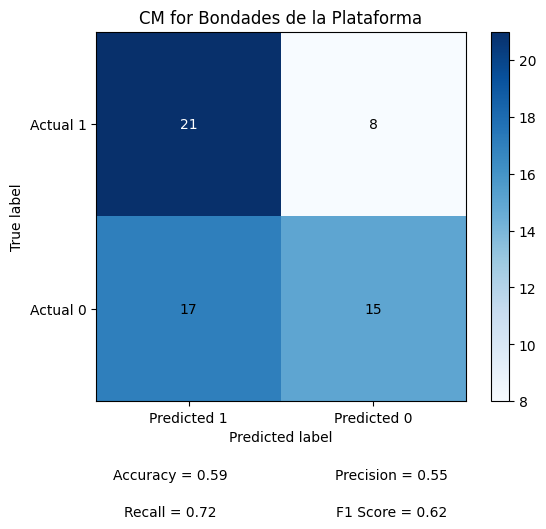

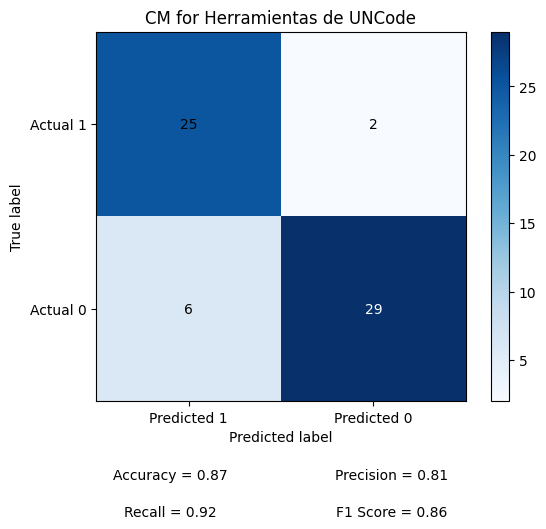

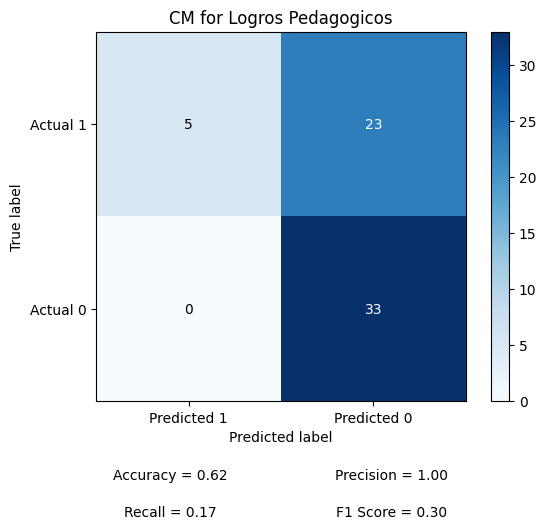

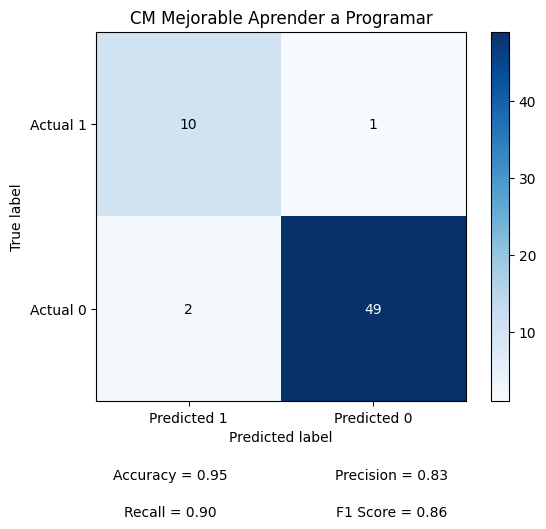

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, classification_report


def plot_confusion_matrix(TP, TN, FP, FN, title='Confusion Matrix'):
    # Create a 2x2 matrix with the values
    cm = np.array([[TP, FN], [FP, TN]])

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # Labels and title
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['Predicted 1', 'Predicted 0'],
           yticklabels=['Actual 1', 'Actual 0'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Annotate each cell with the numeric value
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > (TP + TN) / 2 else "black")

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    if TP + FN ==0:
      recall = "N.A"
    else:
      recall = TP / (TP + FN)

    if TP + FN ==0 or precision + recall == 0:
      f1_score = "N.A"
    else:
      f1_score = 2 * (precision * recall) / (precision + recall)

    # Annotate metrics
    ax.text(0.2, -0.2, f'Accuracy = {accuracy:.2f}', ha='center', va='center', transform=ax.transAxes)
    ax.text(0.8, -0.2, f'Precision = {precision:.2f}', ha='center', va='center', transform=ax.transAxes)
    ax.text(0.2, -0.3, f'Recall = { str(recall)[:4]}', ha='center', va='center', transform=ax.transAxes)
    ax.text(0.8, -0.3, f'F1 Score = { str(f1_score)[:4]}', ha='center', va='center', transform=ax.transAxes)

    plt.show()
#  Bondades de la Plataforma
TP = 21
TN = 15
FP = 17
FN = 8

plot_confusion_matrix(TP, TN, FP, FN, title='CM for Bondades de la Plataforma')

# HerramientasUNcode
TP = 25
TN = 29
FP = 6
FN = 2

plot_confusion_matrix(TP, TN, FP, FN, title='CM for Herramientas de UNCode')

# Logros pedagogicos
TP = 5
TN = 33
FP = 0
FN = 23

plot_confusion_matrix(TP, TN, FP, FN, title='CM for Logros Pedagogicos')

# MejorableAprenderProgramar
TP = 10
TN = 49
FP = 2
FN = 1

plot_confusion_matrix(TP, TN, FP, FN, title='CM Mejorable Aprender a Programar')

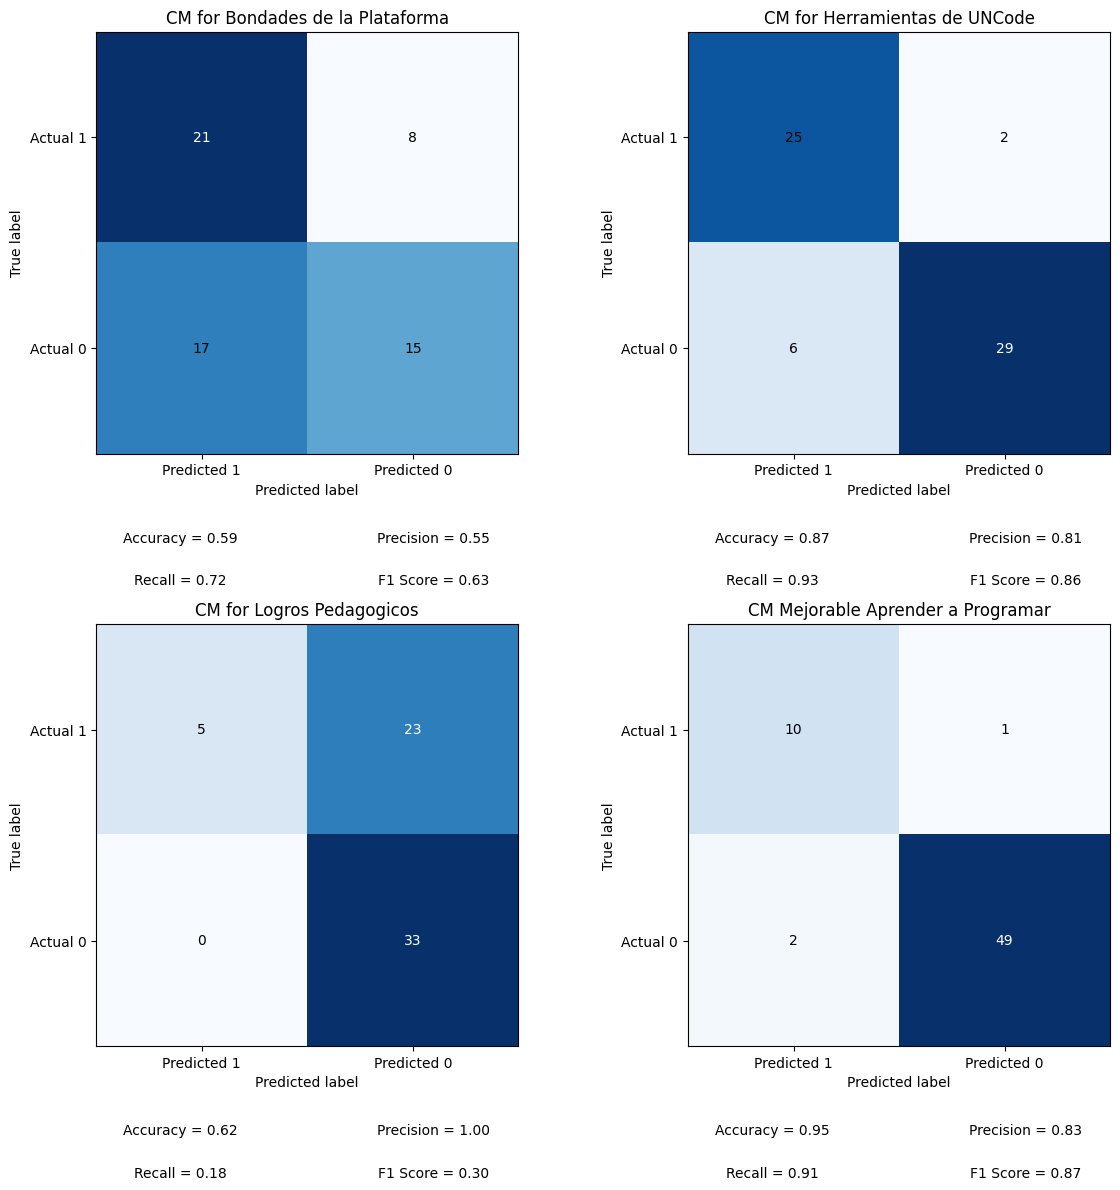

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(TP, TN, FP, FN, title='Confusion Matrix', ax=None):
    # Create a 2x2 matrix with the values
    cm = np.array([[TP, FN], [FP, TN]])

    if ax is None:
        fig, ax = plt.subplots()

    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Labels and title
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['Predicted 1', 'Predicted 0'],
           yticklabels=['Actual 1', 'Actual 0'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Annotate each cell with the numeric value
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > (TP + TN) / 2 else "black")

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Annotate metrics
    ax.text(0.2, -0.2, f'Accuracy = {accuracy:.2f}', ha='center', va='center', transform=ax.transAxes)
    ax.text(0.8, -0.2, f'Precision = {precision:.2f}', ha='center', va='center', transform=ax.transAxes)
    ax.text(0.2, -0.3, f'Recall = {recall:.2f}', ha='center', va='center', transform=ax.transAxes)
    ax.text(0.8, -0.3, f'F1 Score = {f1_score:.2f}', ha='center', va='center', transform=ax.transAxes)

# Create a 2x2 grid for the confusion matrices
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
plot_confusion_matrix(21, 15, 17, 8, title='CM for Bondades de la Plataforma', ax=axs[0, 0])
plot_confusion_matrix(25, 29, 6, 2, title='CM for Herramientas de UNCode', ax=axs[0, 1])
plot_confusion_matrix(5, 33, 0, 23, title='CM for Logros Pedagogicos', ax=axs[1, 0])
plot_confusion_matrix(10, 49, 2, 1, title='CM Mejorable Aprender a Programar', ax=axs[1, 1])

plt.tight_layout()
plt.show()
